In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision import models

In [3]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(256, padding=16),
    transforms.RandomRotation(degrees=30), #This rotates the image by a random angle between –30 and +30 degrees.
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.74856972, 0.72743281, 0.70510449],
        std=[0.30954896, 0.31524588, 0.33628213]
    )
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.74856972, 0.72743281, 0.70510449), (0.30954896, 0.31524588, 0.33628213))
])


In [4]:
# -----------------------------
# 2. Load full dataset
# -----------------------------
data_dir = "../data/images"
full_dataset = datasets.ImageFolder(root=data_dir, transform=None)  # no transform yet

# -----------------------------
# 3. Split indices per class
# -----------------------------
random.seed(42)

train_indices, test_indices = [], []
class_to_indices = {i: [] for i in range(len(full_dataset.classes))}
for idx, (_, label) in enumerate(full_dataset.samples):
    class_to_indices[label].append(idx)

for indices in class_to_indices.values():
    n_total = len(indices)
    n_test = int(0.2 * n_total)
    shuffled = indices.copy()
    random.shuffle(shuffled)
    test_indices.extend(shuffled[:n_test])
    train_indices.extend(shuffled[n_test:])

# -----------------------------
# 4. Split train into train + val
# -----------------------------
train_size = int(0.8 * len(train_indices))
val_size = len(train_indices) - train_size
random.shuffle(train_indices)
train_split_indices = train_indices[:train_size]
val_split_indices = train_indices[train_size:]

# -----------------------------
# 5. Create subsets with directory-level transform
# -----------------------------
train_dataset = Subset(datasets.ImageFolder(root=data_dir, transform=transform_train), train_split_indices)
val_dataset = Subset(datasets.ImageFolder(root=data_dir, transform=transform_test), val_split_indices)
test_dataset = Subset(datasets.ImageFolder(root=data_dir, transform=transform_test), test_indices)

# -----------------------------
# 6. DataLoaders
# -----------------------------
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:

class ResNet50FineTune(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Load pretrained model
        self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        # Freeze everything
        for param in self.model.parameters():
            param.requires_grad = False

        # Unfreeze ONLY last block (layer4)
        for param in self.model.layer4.parameters():
            param.requires_grad = True

        # Replace classifier
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)
    
ResNet_model = ResNet50FineTune(num_classes=30).to(device)
print("ResNet Model Summary:")
print(ResNet_model)
print(f"Total parameters: {sum(p.numel() for p in ResNet_model.parameters())}")

ResNet Model Summary:
ResNet50FineTune(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsa

In [7]:
# TODO: Define loss criterion and optimizer (2 marks)
criterion = nn.CrossEntropyLoss()
ResNet_optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, ResNet_model.parameters()),
    lr=1e-4
)

In [8]:
# TODO: Training loop (3 marks)
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

In [9]:
# TODO: Validation loop (2 marks)
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            running_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    val_loss = running_loss / len(val_loader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

In [10]:
# TODO: Create plotting functions (2 marks)
def plot_losses(train_losses, val_losses, model_name):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_confusion_matrix(model, test_loader, device, class_names):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = output.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    cm = confusion_matrix(all_targets, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, cmap='Blues')
    plt.xticks(rotation=45)
    plt.title('Confusion Matrix')
    plt.show()

In [12]:
# TODO: Run Training and validation loops for CNN (2 marks)
ResNet_train_losses = []
ResNet_val_losses = []
ResNet_train_accs = []
ResNet_val_accs = []

epochs = 5

print("Training ResNet...")
for epoch in range(epochs):
    train_loss, train_acc = train(ResNet_model, train_loader, ResNet_optimizer, criterion, device)
    val_loss, val_acc = validate(ResNet_model, val_loader, criterion, device)
    
    ResNet_train_losses.append(train_loss)
    ResNet_val_losses.append(val_loss)
    ResNet_train_accs.append(train_acc)
    ResNet_val_accs.append(val_acc)
    
    print(f'Epoch {epoch+1}/{epochs}:')
    print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

Training ResNet...
Epoch 1/5:
  Train Loss: 0.4854, Train Acc: 83.97%
  Val Loss: 0.4918, Val Acc: 84.58%
Epoch 2/5:
  Train Loss: 0.3357, Train Acc: 88.70%
  Val Loss: 0.4377, Val Acc: 85.25%
Epoch 3/5:
  Train Loss: 0.2394, Train Acc: 91.75%
  Val Loss: 0.4434, Val Acc: 85.42%
Epoch 4/5:
  Train Loss: 0.2033, Train Acc: 92.72%
  Val Loss: 0.4447, Val Acc: 85.38%
Epoch 5/5:
  Train Loss: 0.1556, Train Acc: 94.36%
  Val Loss: 0.4168, Val Acc: 86.67%


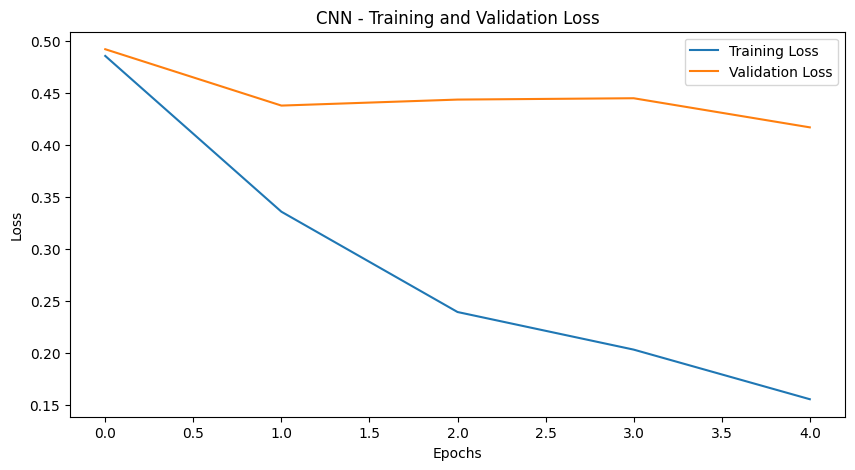

In [13]:
# TODO: Plot losses for ResNet
plot_losses(ResNet_train_losses, ResNet_val_losses, "CNN")

In [14]:
# TODO: Test loop (3 marks)
def test(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()
            
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    test_loss /= len(test_loader)
    test_acc = 100. * correct / total
    return test_loss, test_acc

print("Testing ResNet...")
ResNet_test_loss, ResNet_test_acc = test(ResNet_model, test_loader, device)
print(f"ResNet Test Loss: {ResNet_test_loss:.4f}, Test Accuracy: {ResNet_test_acc:.2f}%")

Testing ResNet...
ResNet Test Loss: 0.4550, Test Accuracy: 85.70%


In [ ]:
# Plot confusion matrix for the best model
class_names = full_dataset.classes

# Use CNN as it typically performs better
plot_confusion_matrix(ResNet_model, test_loader, device, class_names)